In [1]:
import wradlib as wrl
import pyart
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [23]:
#input ffn
radar_ffn    = '/g/data1a/kl02/jss548/hail-research/radar_data/CP2_20141127/044059.mdv'
srtm_ffn     = '/g/data1a/kl02/jss548/hail-research/srtm/srtm_67_18_Brisbane/srtm_67_18.tif'
WRADLIB_DATA = ''

#read using pyart
radar        = pyart.io.read(radar_ffn)

#site parameters
radar_lat  = radar.latitude['data'][0]
radar_lon  = radar.longitude['data'][0]
radar_alt  = radar.altitude['data'][0]
radar_refl = radar.fields['reflectivity']['data']

sitecoords = (radar_lon, radar_lat, radar_alt)
nsweeps    = radar.nsweeps
nrays      = int(radar.nrays / nsweeps)
nbins      = int(radar.ngates)
el_list    = radar.fixed_angle['data']
bw         = radar.instrument_parameters['radar_beam_width_h']['data'][0]
range_res  = radar.range['meters_between_gates']

#grid arrays
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

radar_ccb = np.zeros_like(radar_refl)
radar_alt = np.zeros_like(radar_refl)

for tilt, el in enumerate(el_list):
    #current slice
    sweep_idx = radar.get_slice(tilt)
    
    #calculate lon, lat and alt
    coord  = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
    
    coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                          np.degrees(coord[..., 1]),
                                          coord[..., 2], sitecoords)
    lon       = coords[..., 0]
    lat       = coords[..., 1]
    alt       = coords[..., 2]
    polcoords = coords[..., :2]
    rlimits   = (lon.min(), lat.min(), lon.max(), lat.max())
    
    ds = wrl.io.open_raster(srtm_ffn)
    rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=-32768.)

    # Clip the region inside our bounding box
    ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
    rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
    rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

    # Map rastervalues to polar grid points
    polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues,
                                                 polcoords, order=3,
                                                 prefilter=False)

    #calculate beam blocking for each bin
    PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
    PBB = np.ma.masked_invalid(PBB)

    #calculate beam blocking along each ray
    CBB = wrl.qual.cum_beam_block_frac(PBB)
    
    radar_ccb[sweep_idx] = CBB
    radar_alt[sweep_idx] = alt
    
print('finished')

finished


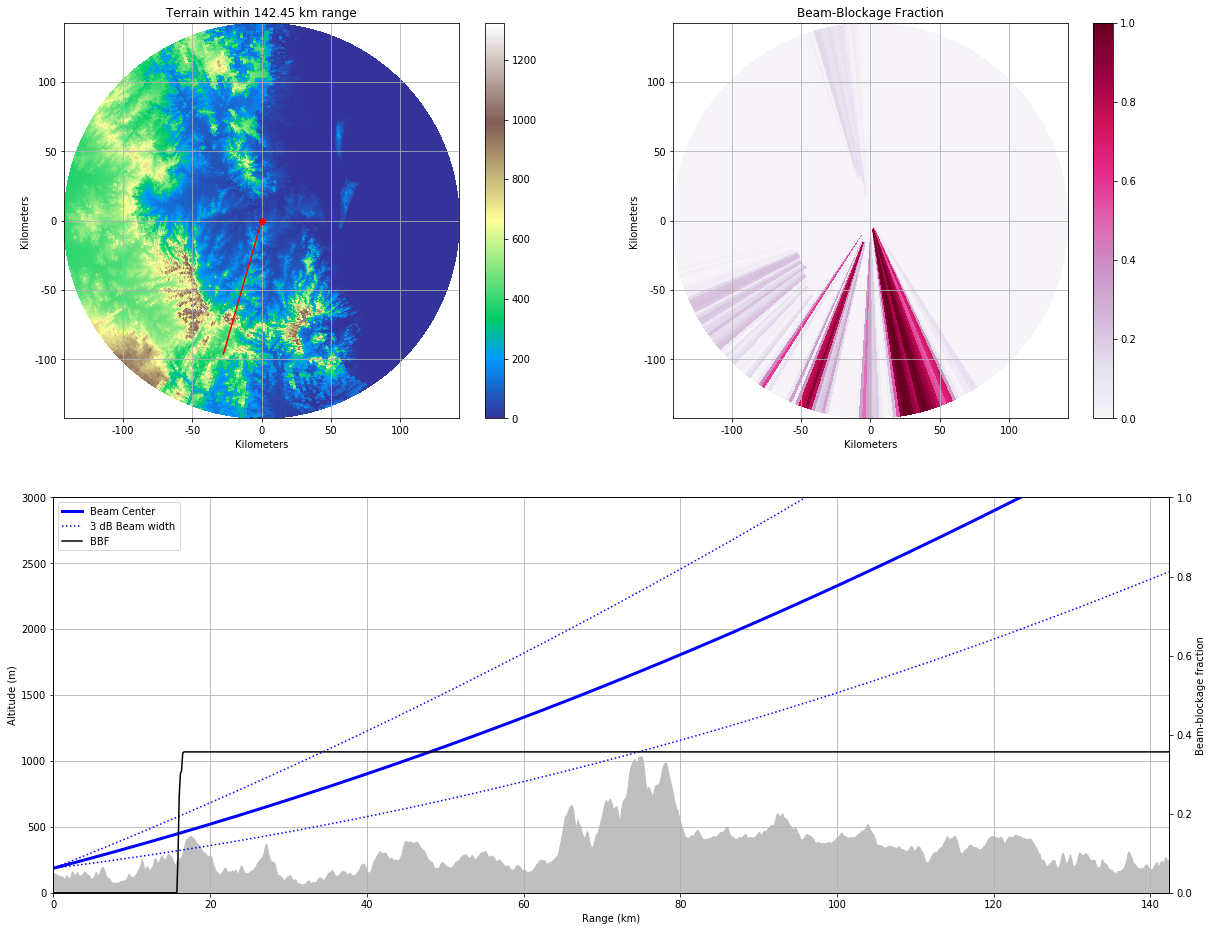

In [27]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks()/1000).astype(np.int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks()/1000).astype(np.int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    if not cm is None:
        pl.colorbar(cm, ax=ax)
    if not title=="":
        ax.set_title(title)
    ax.grid()
    
fig = pl.figure(figsize=(20, 16),facecolor='w')

# create subplots
ax1 = pl.subplot2grid((2, 2), (0, 0))
ax2 = pl.subplot2grid((2, 2), (0, 1))
ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 196
tilt  = 0

cbb_plot = radar_ccb[radar.get_slice(0)]
alt_plot = radar_alt[radar.get_slice(0)]

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(polarvalues,
                            ax=ax1, r=r,
                            az=np.degrees(coord[:,0,1]),
                            cmap=mpl.cm.terrain, vmin=0.)
ax1.plot([0,np.sin(np.radians(angle))*1e5],
         [0,np.cos(np.radians(angle))*1e5],"r-")
ax1.plot(sitecoords[0], sitecoords[1], 'ro')
annotate_map(ax1, dem, 'Terrain within {0} km range'.format(np.max(r / 1000.) + 0.1))

# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(cbb_plot, ax=ax2, r=r,
                            az=np.degrees(coord[:,0,1]),
                            cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax2, cbb, 'Beam-Blockage Fraction')

# Plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., radar_alt[angle, :], '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (radar_alt[angle, :] + beamradius), ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (radar_alt[angle, :] - beamradius), ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :],
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 3000)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Altitude (m)')
ax3.grid()

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., cbb_plot[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., np.max(r / 1000.) + 0.1)


legend = ax3.legend((bc, b3db, bbf),
                    ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)